In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch

/home/m123/anaconda3/envs/cogvlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import cv2
import mat73
import numpy as np
import cv2
import os
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.widgets import RectangleSelector
import math

In [3]:
np.random.seed(42)

folder_dir = 'data_np/'

mat_files = sorted([file for file in os.listdir(folder_dir) if file.endswith('.npy')])
idx = 8

print(mat_files[idx])

40s_long_heating_transm_50Hz_15J_-70°C_2.npy


In [4]:
image_sequence = np.load(folder_dir + mat_files[idx])
image_sequence = image_sequence[135:, :, :]
roi_coords = []

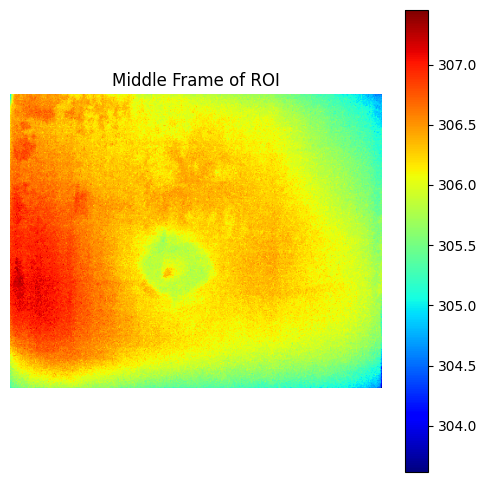

In [5]:
# y1, y2, x1, x2 = 72, 316, 159, 410
# image_sequence = image_sequence[y1:y2, x1:x2, :]

image_sequence = image_sequence[5:, 110:540, :]

h, w, t = image_sequence.shape
middle_frame = image_sequence[:, :, t // 2]
plt.figure(figsize=(6, 6))
plt.imshow(middle_frame, cmap='jet')
plt.title('Middle Frame of ROI')
plt.axis('off')
plt.colorbar()
plt.show()

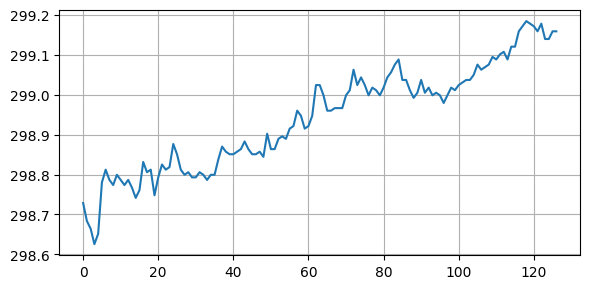

600


In [6]:
h, w, sequence_size = image_sequence.shape
plt.figure(figsize=(6, 3))
plt.plot(image_sequence.reshape(h * w, sequence_size)[5000,173:300])
plt.grid(True)
plt.tight_layout()
plt.show()

diff = np.diff(image_sequence.reshape(h * w, sequence_size)[5000,:1000])
t_pulse = np.argmax(diff)
print(t_pulse)
t_pulse = 95

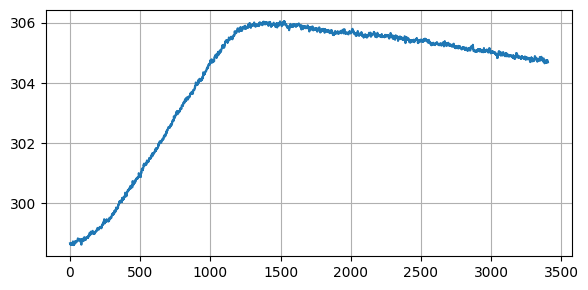

In [7]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

h, w, sequence_size = image_sequence.shape
imageMatrix = image_sequence.reshape(h * w, sequence_size)
imageMatrix = imageMatrix[:, t_pulse:]

plt.figure(figsize=(6, 3))
plt.plot(imageMatrix[5000, :])
plt.grid(True)
plt.tight_layout()
plt.show()

n_components = 10
latent_dim = n_components

In [8]:
imageMatrix = imageMatrix - np.mean(imageMatrix, axis=1, keepdims=True)

U, S, Vh = np.linalg.svd(imageMatrix, full_matrices=False)

Vh = Vh[:n_components, :]

principal_comp = np.matmul(imageMatrix, Vh.T)

pca_array = principal_comp.reshape(h, w, n_components)
pca_array = pca_array.transpose(2, 0, 1)

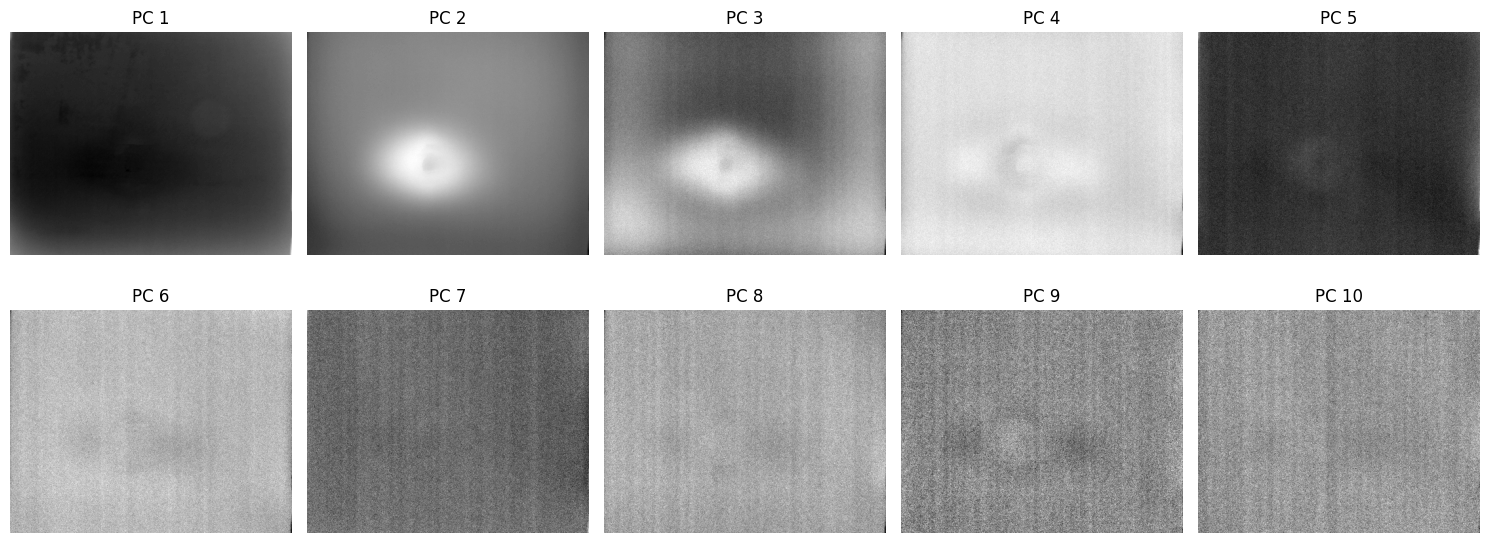

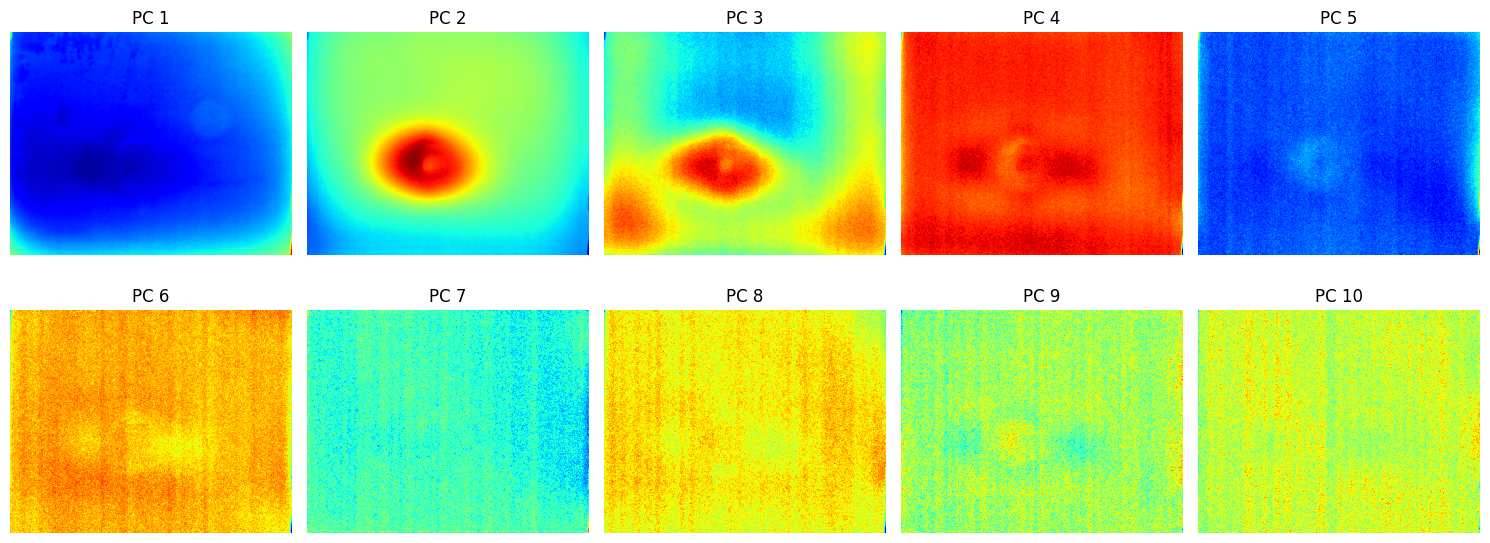

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='jet')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

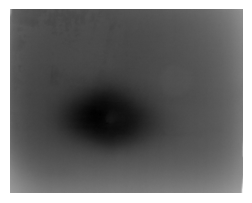

In [10]:
from sklearn.decomposition import PCA

C, H, W = pca_array.shape

flat = pca_array.reshape(C, -1).T
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(flat)

explained_var_ratio = pca.explained_variance_ratio_

pca_images = pca_result.T.reshape(n_components, H, W)

eps = 1e-8
mins = pca_images.min(axis=(1, 2), keepdims=True)
maxs = pca_images.max(axis=(1, 2), keepdims=True)
normalized = (pca_images - mins) / (maxs - mins + eps)

combined = np.average(normalized, axis=0, weights=explained_var_ratio)

combined -= combined.min()
combined /= (combined.max() + eps)
combined = (combined * 255).astype(np.uint8)

import cv2
img_rgb = cv2.cvtColor(combined, cv2.COLOR_GRAY2RGB)

import matplotlib.pyplot as plt
plt.figure(figsize=(3, 3))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [11]:
import torch
import requests
from PIL import Image
from transformers import AutoModelForCausalLM, LlamaTokenizer

tokenizer = LlamaTokenizer.from_pretrained("lmsys/vicuna-7b-v1.5", use_fast=False)
model = AutoModelForCausalLM.from_pretrained(
    "THUDM/cogvlm-grounding-generalist-hf",
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
).eval()

/home/m123/anaconda3/envs/cogvlm/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 8/8 [01:14<00:00,  9.34s/it]
/home/m123/anaconda3/envs/cogvlm/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [12]:
from PIL import Image, ImageDraw

image = Image.fromarray(img_rgb).convert("RGB")
W, H = image.size

save_path = "temp_image.jpg"
image.save(save_path)

In [16]:
query = (
    "Locate every defect in the thermal image. "
    "For each defect, output exactly in this format: [x1,y1,x2,y2], where coordinates are integers between 0 and 1000. "
    "Return only a list of such coordinate arrays, nothing else."
)

In [17]:
image = Image.open(save_path).convert("RGB")

inputs = model.build_conversation_input_ids(tokenizer, query=query, images=[image])
inputs = {
    'input_ids': inputs['input_ids'].unsqueeze(0).to('cuda'),
    'token_type_ids': inputs['token_type_ids'].unsqueeze(0).to('cuda'),
    'attention_mask': inputs['attention_mask'].unsqueeze(0).to('cuda'),
    'images': [[inputs['images'][0].to('cuda').to(torch.bfloat16)]],
}


with torch.no_grad():
    output = model.generate(**inputs, max_length=2048, do_sample=False, use_cache=True)
    output_text = tokenizer.decode(output[0][inputs["input_ids"].shape[1]:])

print(output_text)

</s>


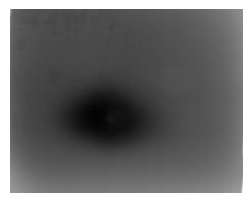

</s>
boxes (0–1000): []
boxes (pixels): []


In [18]:
import json
import re
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt

m = re.search(r"\{.*\}", output_text, flags=re.S)
boxes_rel = []
if m:
    try:
        boxes_rel = json.loads(m.group(0)).get("boxes", [])
    except:
        boxes_rel = []
if not boxes_rel:
    arr = re.findall(r"\[\s*\[\s*\d+\s*,\s*\d+\s*,\s*\d+\s*,\s*\d+\s*\](?:\s*,\s*\[\s*\d+\s*,\s*\d+\s*,\s*\d+\s*,\s*\d+\s*\]\s*)*\s*\]", output_text)
    if arr:
        try:
            boxes_rel = json.loads(arr[0])
        except:
            boxes_rel = []

boxes_px = []
for b in boxes_rel:
    if isinstance(b, (list, tuple)) and len(b) == 4:
        x1 = int(round(b[0] / 1000.0 * W)); y1 = int(round(b[1] / 1000.0 * H))
        x2 = int(round(b[2] / 1000.0 * W)); y2 = int(round(b[3] / 1000.0 * H))
        if x2 > x1 and y2 > y1:
            boxes_px.append((x1, y1, x2, y2))

img_bgr = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
for (x1, y1, x2, y2) in boxes_px:
    cv2.rectangle(img_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure(figsize=(3, 3))
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

print(output_text)
print("boxes (0–1000):", boxes_rel)
print("boxes (pixels):", boxes_px)